# Convert nldas soil data to new netcdf file, that has more cf-standards to work with R tools.  Goal to write file as a standard cf-compliant netCDF file based on original data.


In [15]:
"""Example notebook to work with nldas soil moisture netcdf files."""

import geopandas as gpd
import numpy as np
import time
import pickle
import xarray as xr
import cftime
import datetime
from datetime import timedelta
import rioxarray
import pandas as pd

In [43]:
# variables
start = '2019-01-01 12:00'
end = '2019-12-31 12:00'
ncfile = '../data/bas_ref_all/noah_sm_d_2019.nc'
shpfile = '../data/bas_ref_all/bas_ref_all.shp'
new_ncfile = '../data/bas_ref_all/noan_sm_d_1981_newa.nc'

In [44]:
ds = xr.open_dataset(ncfile)
# ds['lon'] = ds.attrs['Lon']
# ds['lat'] = ds.attrs['Lat']

### The issue with the existing netCDF file is that the data variables, for example SoilM_0_10cm, were dimensioned with lat and lon instead of the actual coordinates latitude and longitude.  Also adds a spatial reference using rio.write_crs, and adds that to the grid_mapping attribute of the data variables.  This works for out case but may not be specifically cf correct.  See  NCEI NetCDF Templates (noaa.gov): https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/index.html

In [45]:
ds

<xarray.Dataset>
Dimensions:          (lat: 224, lon: 464, JD: 365, Latitude: 224, Longitude: 464)
Coordinates:
  * Latitude         (Latitude) float64 25.06 25.19 25.31 ... 52.69 52.81 52.94
  * Longitude        (Longitude) float64 -124.9 -124.8 -124.7 ... -67.19 -67.06
Dimensions without coordinates: lat, lon, JD
Data variables:
    SoilM_0_10cm     (lat, lon, JD) float64 ...
    SoilM_10_40cm    (lat, lon, JD) float64 ...
    SoilM_40_100cm   (lat, lon, JD) float64 ...
    SoilM_100_200cm  (lat, lon, JD) float64 ...
Attributes:
    creation_date:   22-Jul-2021 03:50:13
    Shortname:       NLDAS_NOAH0125_H_2.0
    Map_projection:  EQUIDISTANT CYLINDRICAL
    Title:           NLDAS Noah Land Surface Model L4 Hourly 0.125 x 0.125 de...

In [46]:
tstart = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M")
times = np.array([tstart + timedelta(days=d) for d in range(365)])
simple_times = np.arange(365)
time_units = 'days since {:%Y-%m-%d 00:00}'.format(times[0])
# time_vals = cftime.date2num(times, time_units, calendar='standard', has_year_zero=None)
dates = pd.date_range(start=start, end=end, freq='1d') # better method of generating dates per Signells help to MW
time_vals = cftime.date2num(times, time_units, calendar='standard', has_year_zero=None)
# here we are reordering the dims from lat,lon,time to time,lat,lon -appears to be key to work with R-code
SoilM_0_10cm = ds['SoilM_0_10cm'].transpose('JD', 'lat', 'lon').values
SoilM_10_40cm = ds['SoilM_10_40cm'].transpose('JD', 'lat', 'lon').values
SoilM_40_100cm = ds['SoilM_40_100cm'].transpose('JD', 'lat', 'lon').values
SoilM_100_200cm = ds['SoilM_100_200cm'].transpose('JD', 'lat', 'lon').values

ds_new = xr.Dataset({'SoilM_0_10cm': (['time', 'lat', 'lon'], SoilM_0_10cm, {'units': 'percent'}),
                    'SoilM_10_40cm': (['time', 'lat', 'lon'], SoilM_10_40cm, {'units': 'percent'}),
                    'SoilM_40_100cm': (['time', 'lat', 'lon'], SoilM_40_100cm, {'units': 'percent'}),
                    'SoilM_100_200cm': (['time', 'lat', 'lon'], SoilM_100_200cm, {'units': 'percent'})},
                    coords={'lat': (['lat'], ds['Latitude'].values, {'units':'degrees_north'}), 
                            'lon': (['lon'], ds['Longitude'].values, {'units':'degrees_east'}), 
                            'time': (['time'], dates)})
ds_new.time.encoding['units'] = time_units

In [47]:
end

'2019-12-31 12:00'

In [48]:
# This addes the spatial reference to the data
ds_new = ds_new.rio.write_crs('epsg:4326')

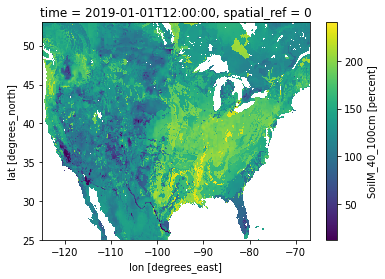

In [50]:
# test plot
ds_new.SoilM_40_100cm.sel(time='2019-01-01').plot(x='lon', y='lat')

In [51]:
#https://pyproj4.github.io/pyproj/stable/build_crs_cf.html#exporting-crs-to-cf
# link above provides some nice tools for getting proj information.

# information from variables below will be used to add metadata to new netcdf file.
from pyproj import CRS
crs = CRS("epsg:4326")
cf_grid_mapping = crs.to_cf()
cf_coordinate_system = crs.cs_to_cf()
print(cf_coordinate_system[0]['axis'])
print(cf_grid_mapping)
crs

Y
{'crs_wkt': 'GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]', 'semi_major_axis': 6378137.0, 'semi_minor_axis': 6356752.314245179, 'inverse_flattening': 298.257223563, 'reference_ellipsoid_name': 'WGS 84', 'longitude_of_prime_meridian': 0.0, 'prime_meridian_name': 'Greenwich', 'geographic_crs_name': 'WGS 84', 'grid_mapping_name': 'latitude_longitude'}


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [52]:
ds_new.lat.attrs['axis'] = cf_coordinate_system[0]['axis']
ds_new.lat.attrs['standard_name'] = cf_coordinate_system[0]['standard_name']
ds_new.lat.attrs['long_name'] = cf_coordinate_system[0]['long_name']
ds_new.lat.attrs['units'] = cf_coordinate_system[0]['units']

ds_new.lon.attrs['axis'] = cf_coordinate_system[1]['axis']
ds_new.lon.attrs['standard_name'] = cf_coordinate_system[1]['standard_name']
ds_new.lon.attrs['long_name'] = cf_coordinate_system[1]['long_name']
ds_new.lon.attrs['units'] = cf_coordinate_system[1]['units']

ds_new.SoilM_0_10cm.attrs['grid_mapping'] = 'spatial_ref'
ds_new.SoilM_10_40cm.attrs['grid_mapping'] = 'spatial_ref'
ds_new.SoilM_40_100cm.attrs['grid_mapping'] = 'spatial_ref'
ds_new.SoilM_100_200cm.attrs['grid_mapping'] = 'spatial_ref'

ds_new.to_netcdf(new_ncfile)

In [53]:
ds2 = xr.open_dataset(new_ncfile)

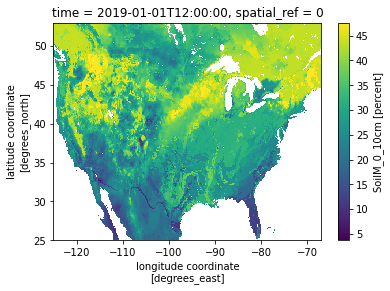

In [54]:
ds2.SoilM_0_10cm.isel(time=0).plot(x='lon', y='lat')